<a href="https://colab.research.google.com/github/RomainCendre/DSTest/blob/main/deepsense_generative_takehome_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Data modeling

Given the following [data-set](https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json).



In [1]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

# Read the Gist
res = requests.get("https://gist.githubusercontent.com/alephd/e3899eaae0e7869e9c230f6a0fe944e5/raw/deab4f93a9c15224ac118d46533d9ea9700d206a/2019_data_science_test.json")
data = np.array(res.json())
print(data.shape)

(1542, 7)


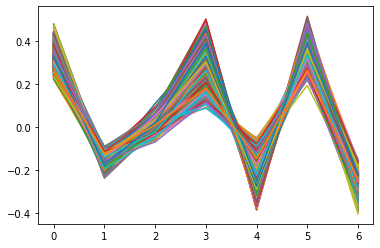

In [2]:
plt.plot(data.T);

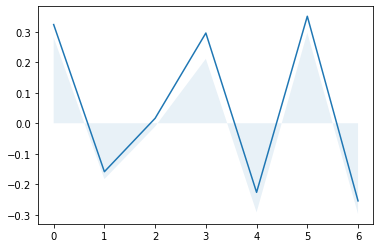

In [3]:
def mean_and_deviation(y):
    figure, axe = plt.subplots()
    x = range(y.shape[1])
    axe.plot(x, y.mean(axis=0))
    axe.fill_between(x, y.mean(axis=0) - y.std(axis=0), alpha=0.1)
    return figure
  
mean_and_deviation(data);

In [4]:
# plt.hist(data.T, bins=10);

### 1. Can you generate 10k rows of new data from the same distribution?
Following considered data as (n_samples, n_features) shape like most library does.

Depend on the purpose but this has been a long topic to counter imbalanced data annotation during the training phase. Nowadays, such ideas are not used only to counter imbalanced data issues, but also in classification topics when the number of data is insufficient.

I will distinguish two main categories :
*   Generation based on linear functions, basically consist in generating new sample by interpolation of existing data points (1990-2010)
*   Generation based on deep learning, with generative models (last decade)

In [5]:
nb_samples = 1000; # 1000 for test

#### LINEAR


##### SIMPLE INTERPOLATION

In [6]:
from random import random, randint

def generate_simple_interp(inputs, number):
  def interpolate(a, b, coeff):
    return a+(a-b)*coeff
  return np.array([interpolate(inputs[randint(0, len(inputs)-1)], inputs[randint(0, len(inputs)-1)], random()) for value in range(number)])

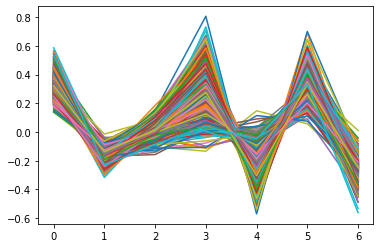

In [7]:
plt.plot(generate_simple_interp(data, nb_samples).T);

##### PCA

In [37]:
from sklearn.decomposition import PCA

def generate_pca(inputs, number, reduce_dim):
  pca = PCA(n_components=reduce_dim)
  pca.fit(data)  
  return np.array([pca.inverse_transform(random())[0] for value in range(number)])


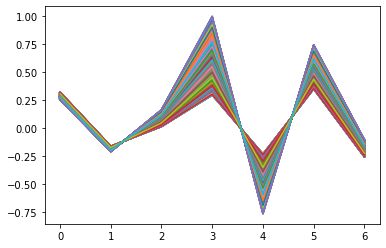

In [38]:
plt.plot(generate_pca(data, nb_samples, 1).T);

#### DEEP LEARNING


##### SIMPLE AE
From the following repository : https://github.com/lbun/VAE_Variational_Autoencoders/blob/master/VAE_Variational_Autoencoders_Part1.ipynb

In [11]:
from keras import callbacks, optimizers, models,layers

class AutoEncoder:

  def __init__(self, latent_dim):    
      self.latent_dim = latent_dim
      self.optimizer = optimizers.Adam()
      self.loss = 'binary_crossentropy'

  def create_model(self, inputs):

      #Input layer
      ae_input = layers.Input(shape=(inputs.shape[1],))  
      encoded = layers.Dense(self.latent_dim, activation='relu')(ae_input)
      decoded = layers.Dense(inputs.shape[1],activation='sigmoid')(encoded) 

      #Autoencoder 
      self.autoencoder = models.Model(ae_input,decoded)

      #Encoder
      encoder = models.Model(ae_input,encoded)

      #Decoder
      encoded_input = layers.Input(shape=(self.latent_dim,))
      decoder_layers = self.autoencoder.layers[-1]  #applying the last layer
      self.decoder = models.Model(encoded_input, decoder_layers(encoded_input))

      self.autoencoder.compile(optimizer=self.optimizer, loss=self.loss)

  def train(self, inputs, epochs=50, batch_size=128):
      self.autoencoder.fit(inputs, inputs, epochs=epochs, batch_size=batch_size, 
                              shuffle=True, validation_split=0.1, 
                              callbacks=[ callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])
      
  def generate_samples(self, inputs, number):
    return self.decoder.predict(np.random.rand(number, 1))


Epoch 1/50
11/11 [==============================] - 1s 56ms/step - loss: 0.6919 - val_loss: 0.6882
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6870 - val_loss: 0.6833
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6821 - val_loss: 0.6785
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6773 - val_loss: 0.6737
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6724 - val_loss: 0.6689
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6677 - val_loss: 0.6642
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6629 - val_loss: 0.6595
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6583 - val_loss: 0.6548
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6536 - val_loss: 0.6502
Epoch 10/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6491 - val_loss: 0.6457
Epoch 11/50
11/11 

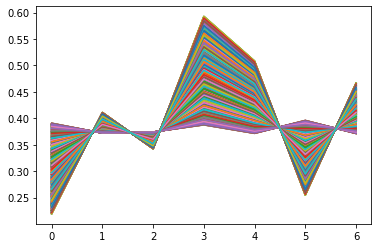

In [12]:
model = AutoEncoder(latent_dim = 1)
model.create_model(data)
model.train(data)
plt.plot(model.generate_samples(data, nb_samples).T);

##### SIMPLE VAE
For this, I will based the implementation on Keras, as compared to GAN, VAE are sequential approach.
From the repository of françois chollet from keras : https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

In [13]:
import tensorflow as tf
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Flatten

class VariationalAutoEncoder:
  class Sampling(layers.Layer):
      def call(self, inputs):
        z_mean, z_log = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log) * epsilon

  def __init__(self, latent_dim):
    self.latent_dim = latent_dim
    self.optimizer = optimizers.Adam()
    self.loss = 'binary_crossentropy'

  def create_model(self, inputs):
      #Input layer
      vae_input = layers.Input(shape=(inputs.shape[1],))  
      z_mean = layers.Dense(self.latent_dim)(vae_input)
      z_log = layers.Dense(self.latent_dim)(vae_input)
      z = VariationalAutoEncoder.Sampling()([z_mean, z_log])
      decoded = layers.Dense(inputs.shape[1], activation='sigmoid')(z) 

      self.vautoencoder = models.Model(vae_input,decoded)

      #Encoder
      encoder = models.Model(vae_input, z)

      #Decoder
      encoded_input = layers.Input(shape=(self.latent_dim,))
      decoder_layers = self.vautoencoder.layers[-1]  #applying the last layer
      self.decoder = models.Model(encoded_input,decoder_layers(encoded_input))

      self.vautoencoder.compile(optimizer=self.optimizer, loss=self.loss)

  def train(self, inputs, epochs=50, batch_size=128):
      self.vautoencoder.fit(inputs, inputs, epochs=epochs, batch_size=batch_size, 
                              shuffle=True, validation_split=0.1, 
                              callbacks=[ callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])
      
  def generate_samples(self, inputs, number):
    return self.decoder.predict(np.random.rand(number, 1))

Epoch 1/50
11/11 [==============================] - 1s 20ms/step - loss: 0.7142 - val_loss: 0.7065
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.7091 - val_loss: 0.7077
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6999 - val_loss: 0.6960
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.6936 - val_loss: 0.6825
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6814 - val_loss: 0.6768
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.6750 - val_loss: 0.6680
Epoch 7/50
11/11 [==============================] - 0s 8ms/step - loss: 0.6641 - val_loss: 0.6565
Epoch 8/50
11/11 [==============================] - 0s 8ms/step - loss: 0.6571 - val_loss: 0.6439
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6453 - val_loss: 0.6387
Epoch 10/50
11/11 [==============================] - 0s 7ms/step - loss: 0.6381 - val_loss: 0.6315
Epoch 11/50
11/11 

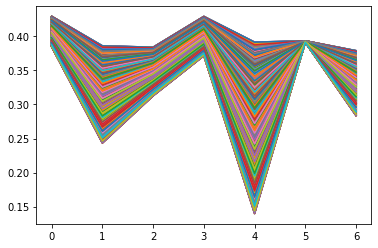

In [14]:
model = VariationalAutoEncoder(latent_dim = 1)
model.create_model(data)
model.train(data)
plt.plot(model.generate_samples(data, nb_samples).T);

##### GAN
Inspired by https://github.com/eriklindernoren/Keras-GAN

In [15]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self, latent_dim=1):
        self.latent_dim = latent_dim 
        self.optimizer = optimizers.Adam()
        self.loss = 'binary_crossentropy'

    def create_model(self, inputs):
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator(inputs)
        self.discriminator.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator(inputs)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img, inputs)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss=self.loss, optimizer=self.optimizer)


    def build_generator(self, inputs):
        generator_input = layers.Input(shape=(self.latent_dim,))
        generator = layers.Dense(inputs.shape[1], activation='sigmoid')(generator_input) 

        return models.Model(generator_input, generator)

    def build_discriminator(self, inputs):
        discriminator_input = layers.Input(shape=(inputs.shape[1],))
        discriminator = layers.Dense(1, activation='sigmoid')(discriminator_input) 

        return models.Model(discriminator_input, discriminator)

    def train(self, inputs, epochs=50, batch_size=128, sample_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, inputs.shape[0], batch_size)
            imgs = inputs[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    def generate_samples(self, inputs, number):
            return self.generator.predict(np.random.rand(number, 1))


0 [D loss: 0.578699, acc.: 91.80%] [G loss: 0.971135]
1 [D loss: 0.579104, acc.: 91.02%] [G loss: 0.972049]
2 [D loss: 0.578398, acc.: 91.80%] [G loss: 0.974002]
3 [D loss: 0.577558, acc.: 92.58%] [G loss: 0.976035]
4 [D loss: 0.574574, acc.: 96.88%] [G loss: 0.977352]
5 [D loss: 0.574946, acc.: 95.31%] [G loss: 0.980267]
6 [D loss: 0.573872, acc.: 94.92%] [G loss: 0.981174]
7 [D loss: 0.573136, acc.: 96.48%] [G loss: 0.983491]
8 [D loss: 0.571468, acc.: 97.66%] [G loss: 0.985375]
9 [D loss: 0.570664, acc.: 98.05%] [G loss: 0.987548]
10 [D loss: 0.569448, acc.: 98.83%] [G loss: 0.989947]
11 [D loss: 0.568929, acc.: 98.44%] [G loss: 0.991262]
12 [D loss: 0.568460, acc.: 98.44%] [G loss: 0.993632]
13 [D loss: 0.567394, acc.: 99.22%] [G loss: 0.995571]
14 [D loss: 0.566306, acc.: 98.83%] [G loss: 0.997855]
15 [D loss: 0.564543, acc.: 99.22%] [G loss: 1.000636]
16 [D loss: 0.562986, acc.: 98.44%] [G loss: 1.002464]
17 [D loss: 0.562365, acc.: 97.27%] [G loss: 1.004434]
18 [D loss: 0.562326

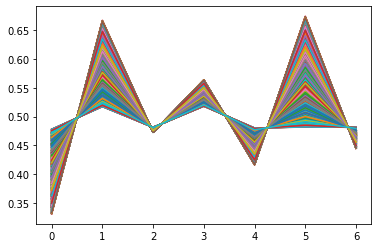

In [16]:
model = GAN(latent_dim = 1)
model.create_model(data)
model.train(data)
plt.plot(model.generate_samples(data, nb_samples).T);


### 2. How could prior-knowledge help you in this task?

In [17]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

# Read the Gist
res = requests.get("https://gist.githubusercontent.com/IdrissMg/695f423af0f0aaffd8d69bc403932c6b/raw/6f3192bbcc328f2aa53ae2faef0cefb825564ea9/data_science_test.json")
data = np.array(res.json())

In [18]:
# The data-set is properly loaded
print(data[:10,:])

[[ 0.35550847 -0.16861307 -0.03649862  0.19952643 -0.11887184  0.29424839
  -0.28051336]
 [ 0.4260113  -0.21258807 -0.01852221  0.22457905 -0.15877081  0.32463416
  -0.37767599]
 [ 0.29133138 -0.1376825   0.0477822   0.36069595 -0.26262892  0.36821576
  -0.22965423]
 [ 0.31290507 -0.15962714  0.05445522  0.33733013 -0.2346064   0.2984015
  -0.20969495]
 [ 0.30500781 -0.13593187 -0.01060943  0.28193989 -0.23838613  0.33592651
  -0.22018852]
 [ 0.31491301 -0.14003621  0.00660586  0.275029   -0.18690363  0.33443304
  -0.27883085]
 [ 0.39339591 -0.13173083  0.0158673   0.18128972 -0.15204574  0.3052976
  -0.34210036]
 [ 0.3136345  -0.15933352  0.00958527  0.28161228 -0.1882738   0.30471432
  -0.2638125 ]
 [ 0.33660039 -0.17667822  0.0593603   0.31968113 -0.28692315  0.38236689
  -0.26209681]
 [ 0.3190583  -0.13005376  0.02983905  0.16937195 -0.13130105  0.23831343
  -0.27769289]]
